In [137]:
import warnings
warnings.filterwarnings('ignore')

In [337]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

from tqdm import tqdm

In [139]:
# !pip install --upgrade "statsmodels>=0.14"

In [140]:
plt.style.use('ggplot')

In [141]:
cpih = pd.read_csv('PAYEMS.csv')
cpih.head()

,observation_date,PAYEMS
0,1939-01-01,29923
1,1939-02-01,30100
2,1939-03-01,30280
3,1939-04-01,30094
4,1939-05-01,30299


In [142]:
cpih['PAYEMS'] = cpih['PAYEMS'].astype(float)

In [143]:
cpih['PAYEMS_delta'] = cpih['PAYEMS'].diff()

In [144]:
cpih['PAYEMS_log'] = np.log(cpih['PAYEMS'])
cpih['PAYEMS_logdelta'] = cpih['PAYEMS_log'].diff()

In [145]:
cpih.head()

,observation_date,PAYEMS,PAYEMS_delta,PAYEMS_log,PAYEMS_logdelta
0,1939-01-01,29923.0,NaN,10.306383,NaN
1,1939-02-01,30100.0,177.0,10.312280,0.005898
2,1939-03-01,30280.0,180.0,10.318243,0.005962
3,1939-04-01,30094.0,-186.0,10.312081,-0.006162
4,1939-05-01,30299.0,205.0,10.318870,0.006789


In [146]:
cpih

,observation_date,PAYEMS,PAYEMS_delta,PAYEMS_log,PAYEMS_logdelta
0,1939-01-01,29923.0,NaN,10.306383,NaN
1,1939-02-01,30100.0,177.0,10.312280,0.005898
2,1939-03-01,30280.0,180.0,10.318243,0.005962
3,1939-04-01,30094.0,-186.0,10.312081,-0.006162
4,1939-05-01,30299.0,205.0,10.318870,0.006789
...,...,...,...,...,...
1035,2025-04-01,159433.0,158.0,11.979379,0.000992
1036,2025-05-01,159452.0,19.0,11.979498,0.000119
1037,2025-06-01,159439.0,-13.0,11.979417,-0.000082
1038,2025-07-01,159518.0,79.0,11.979912,0.000495


In [147]:
cpih['observation_date'] = pd.to_datetime(cpih['observation_date'])

In [148]:
cpih_rec = cpih[cpih['observation_date'] >= pd.to_datetime('2021-01-01')]
cpih_realrec = cpih[cpih['observation_date'] >= pd.to_datetime('2024-01-01')]

Text(0, 0.5, 'CPI for Urban Consumers - Housing')

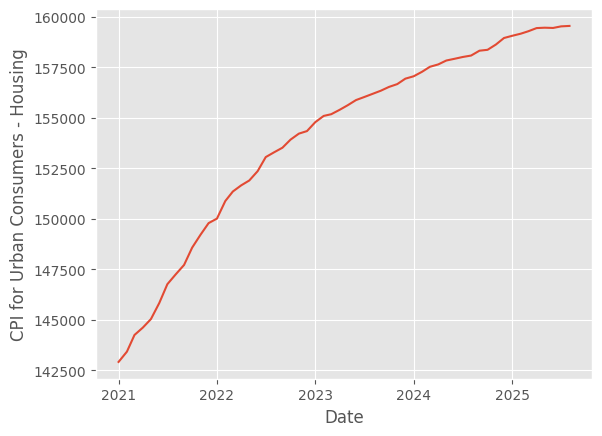

In [149]:
plt.plot(cpih_rec['observation_date'], cpih_rec['PAYEMS'])
plt.xlabel('Date')
plt.ylabel('CPI for Urban Consumers - Housing')

Text(0, 0.5, 'Monthly Change in PAYEMS')

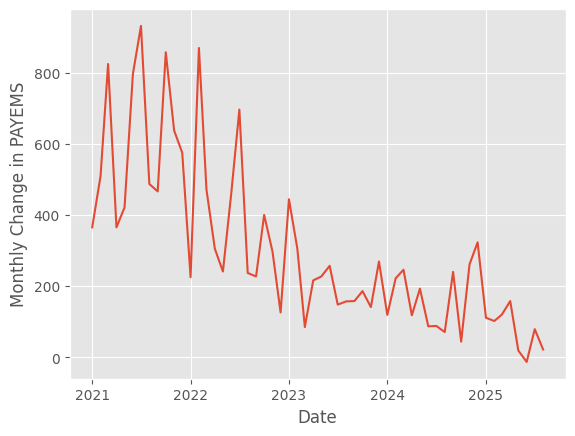

In [335]:
plt.plot(cpih_rec['observation_date'], cpih_rec['PAYEMS_delta'])
plt.xlabel('Date')
plt.ylabel('Monthly Change in PAYEMS')

In [347]:
adf_test = adfuller(cpih['PAYEMS_delta'][1:].values)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])

ADF Statistic: -24.847374
p-value: 0.000000


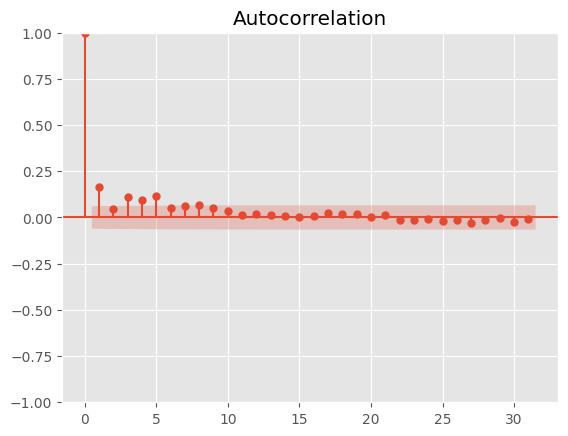

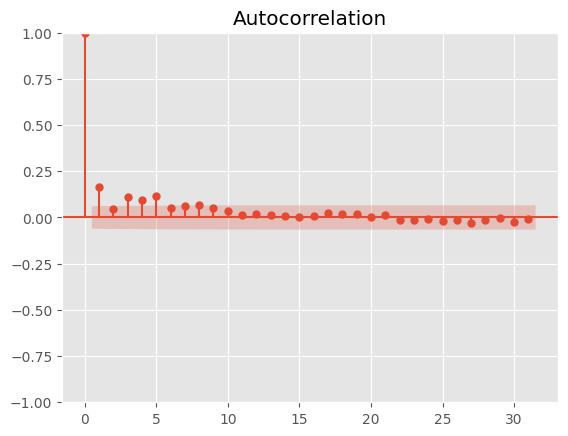

In [151]:
plot_acf(cpih['PAYEMS_logdelta'][1:])

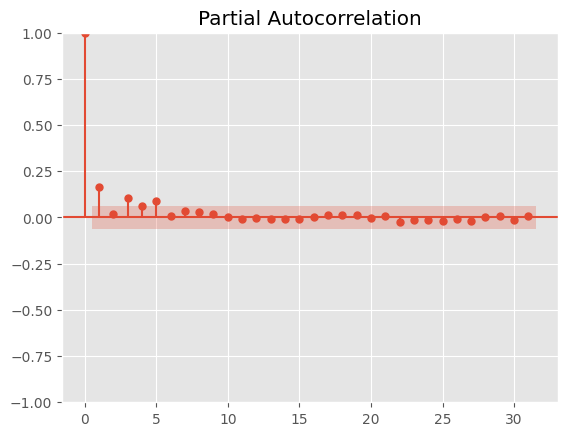

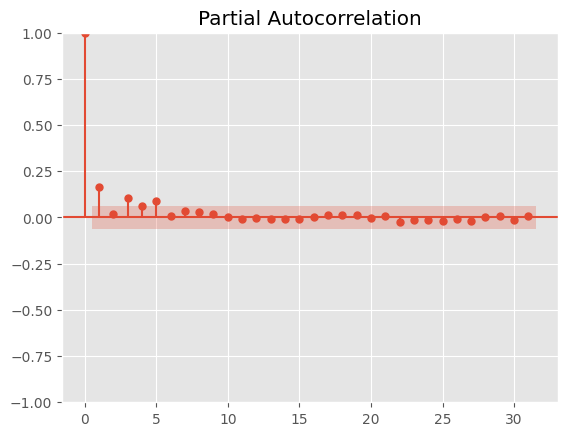

In [152]:
plot_pacf(cpih['PAYEMS_logdelta'][1:])

In [275]:
b = 15

In [277]:
end = cpih['PAYEMS_logdelta'][1:].values.shape[0] - b
end

1024

In [283]:
armod_sm = AutoReg(cpih['PAYEMS_logdelta'][1:end].values, lags = 1, trend = 'c').fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1023
Model:                     AutoReg(1)   Log Likelihood                3768.761
Method:               Conditional MLE   S.D. of innovations              0.006
Date:                Sun, 14 Sep 2025   AIC                          -7531.522
Time:                        18:02:10   BIC                          -7516.734
Sample:                             1   HQIC                         -7525.907
                                 1023                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0014      0.000      6.904      0.000       0.001       0.002
y.L1           0.1644      0.031      5.329      0.000       0.104       0.225
                                    Roots           

In [285]:
k, n_train = b + 1, cpih['PAYEMS_logdelta'][1:end].values.shape[0]
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean
fcast_mean

array([0.00147607, 0.00159561, 0.00161526, 0.00161849, 0.00161902,
       0.00161911, 0.00161912, 0.00161912, 0.00161912, 0.00161912,
       0.00161912, 0.00161912, 0.00161912, 0.00161912, 0.00161912,
       0.00161912])

In [287]:
diffs_with_pred = np.append(cpih['PAYEMS_logdelta'][1:end].values, fcast_mean)
diffs_with_pred.shape

(1039,)

In [289]:
pred_df = pd.DataFrame({'observation_date': cpih['observation_date'][1:], 'diffs': diffs_with_pred}).set_index(['observation_date'])
pred_df

,diffs
observation_date,
1939-02-01,0.005898
1939-03-01,0.005962
1939-04-01,-0.006162
1939-05-01,0.006789
1939-06-01,0.006678
...,...
2025-04-01,0.001619
2025-05-01,0.001619
2025-06-01,0.001619


In [291]:
base = np.log(29923)
pred_df['pred_logcpi'] = pred_df['diffs'].cumsum() + base

In [293]:
pred_df['diffs'][-10:]

observation_date
2024-11-01    0.001619
2024-12-01    0.001619
2025-01-01    0.001619
2025-02-01    0.001619
2025-03-01    0.001619
2025-04-01    0.001619
2025-05-01    0.001619
2025-06-01    0.001619
2025-07-01    0.001619
2025-08-01    0.001619
Name: diffs, dtype: float64

In [295]:
cpih[-10:]

,observation_date,PAYEMS,PAYEMS_delta,PAYEMS_log,PAYEMS_logdelta
1030,2024-11-01,158619.0,261.0,11.974260,0.001647
1031,2024-12-01,158942.0,323.0,11.976295,0.002034
1032,2025-01-01,159053.0,111.0,11.976993,0.000698
1033,2025-02-01,159155.0,102.0,11.977634,0.000641
1034,2025-03-01,159275.0,120.0,11.978388,0.000754
1035,2025-04-01,159433.0,158.0,11.979379,0.000992
1036,2025-05-01,159452.0,19.0,11.979498,0.000119
1037,2025-06-01,159439.0,-13.0,11.979417,-0.000082
1038,2025-07-01,159518.0,79.0,11.979912,0.000495
1039,2025-08-01,159540.0,22.0,11.980050,0.000138


In [297]:
pred_df = pred_df.reset_index()

In [299]:
pred_df['pred_cpi'] = np.exp(pred_df['pred_logcpi'])

In [301]:
pred_df['diffs_real'] = pred_df['pred_cpi'].diff().values

In [303]:
pred_df

,observation_date,diffs,pred_logcpi,pred_cpi,diffs_real
0,1939-02-01,0.005898,10.312280,30100.000000,NaN
1,1939-03-01,0.005962,10.318243,30280.000000,180.000000
2,1939-04-01,-0.006162,10.312081,30094.000000,-186.000000
3,1939-05-01,0.006789,10.318870,30299.000000,205.000000
4,1939-06-01,0.006678,10.325548,30502.000000,203.000000
...,...,...,...,...,...
1034,2025-04-01,0.001619,11.987296,160700.200381,259.982939
1035,2025-05-01,0.001619,11.988915,160960.604605,260.404224
1036,2025-06-01,0.001619,11.990534,161221.430797,260.826192
1037,2025-07-01,0.001619,11.992153,161482.679642,261.248844


In [305]:
pred_df_rec = pred_df[pred_df['observation_date'] >= pd.to_datetime('2021-01-01')]

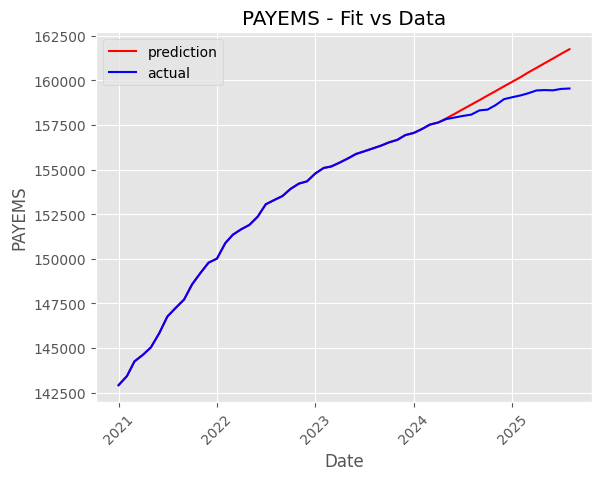

In [307]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['pred_cpi'], label='prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['PAYEMS'], label='actual', color='blue')
plt.xlabel('Date')
plt.ylabel('PAYEMS')
plt.title('PAYEMS - Fit vs Data')
plt.xticks(rotation=45)
plt.legend();

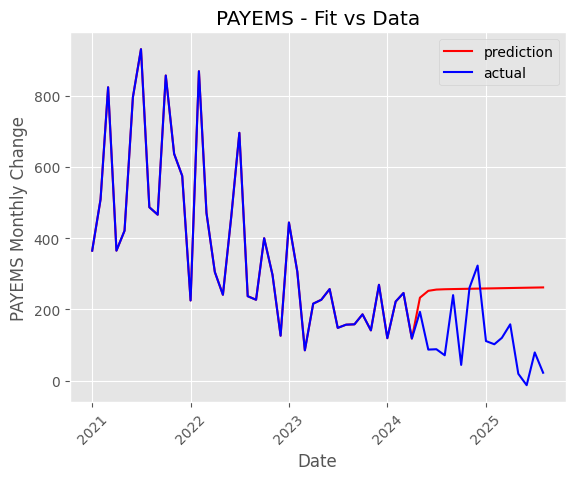

In [309]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['diffs_real'], label='prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['PAYEMS_delta'], label='actual', color='blue')
plt.xlabel('Date')
plt.ylabel('PAYEMS Monthly Change')
plt.title('PAYEMS - Fit vs Data')
plt.xticks(rotation=45)
plt.legend();

In [310]:
armod_sm = AutoReg(cpih['PAYEMS_logdelta'][1:].values, lags = 7).fit()
print(armod_sm.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1039
Model:                     AutoReg(7)   Log Likelihood                3826.069
Method:               Conditional MLE   S.D. of innovations              0.006
Date:                Sun, 14 Sep 2025   AIC                          -7634.137
Time:                        18:02:15   BIC                          -7589.684
Sample:                             7   HQIC                         -7617.268
                                 1039                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      4.522      0.000       0.001       0.001
y.L1           0.1494      0.031      4.807      0.000       0.089       0.210
y.L2          -0.0095      0.031     -0.303      0.7

In [313]:
# Predictions for future
b = 20
k, n_train = b, cpih['PAYEMS_logdelta'][1:].values.shape[0]
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean
fcast_mean

array([0.0010795 , 0.00119109, 0.00118513, 0.00126831, 0.00129444,
       0.00140835, 0.00142856, 0.00147155, 0.00150067, 0.00151375,
       0.00153348, 0.00154363, 0.0015556 , 0.00156299, 0.00156857,
       0.00157372, 0.00157704, 0.00158013, 0.00158232, 0.00158409])

In [315]:
start_date = '2025-09-01'
periods = b

dates_fut = pd.date_range(start=start_date, periods=periods, freq='MS')
dates_fut

DatetimeIndex(['2025-09-01', '2025-10-01', '2025-11-01', '2025-12-01',
               '2026-01-01', '2026-02-01', '2026-03-01', '2026-04-01',
               '2026-05-01', '2026-06-01', '2026-07-01', '2026-08-01',
               '2026-09-01', '2026-10-01', '2026-11-01', '2026-12-01',
               '2027-01-01', '2027-02-01', '2027-03-01', '2027-04-01'],
              dtype='datetime64[ns]', freq='MS')

In [317]:
diffs_with_pred = np.append(cpih['PAYEMS_logdelta'][1:].values, fcast_mean)
diffs_with_pred.shape

(1059,)

In [319]:
pred_df = pd.DataFrame({'observation_date': np.append(cpih['observation_date'][1:].values, dates_fut), 'diffs': diffs_with_pred}).set_index(['observation_date'])
pred_df

,diffs
observation_date,
1939-02-01,0.005898
1939-03-01,0.005962
1939-04-01,-0.006162
1939-05-01,0.006789
1939-06-01,0.006678
...,...
2026-12-01,0.001574
2027-01-01,0.001577
2027-02-01,0.001580


In [321]:
base = np.log(29923)
pred_df['pred_logcpi'] = pred_df['diffs'].cumsum() + base

In [323]:
pred_df = pred_df.reset_index()
pred_df['pred_cpi'] = np.exp(pred_df['pred_logcpi'])
pred_df['diffs_real'] = pred_df['pred_cpi'].diff().values

In [325]:
pred_df

,observation_date,diffs,pred_logcpi,pred_cpi,diffs_real
0,1939-02-01,0.005898,10.312280,30100.000000,NaN
1,1939-03-01,0.005962,10.318243,30280.000000,180.000000
2,1939-04-01,-0.006162,10.312081,30094.000000,-186.000000
3,1939-05-01,0.006789,10.318870,30299.000000,205.000000
4,1939-06-01,0.006678,10.325548,30502.000000,203.000000
...,...,...,...,...,...
1054,2026-12-01,0.001574,12.002729,163199.605353,256.628634
1055,2027-01-01,0.001577,12.004306,163457.180617,257.575264
1056,2027-02-01,0.001580,12.005886,163715.668839,258.488222
1057,2027-03-01,0.001582,12.007469,163974.924013,259.255175


In [327]:
pred_df_rec = pred_df[pred_df['observation_date'] >= pd.to_datetime('2021-01-01')]

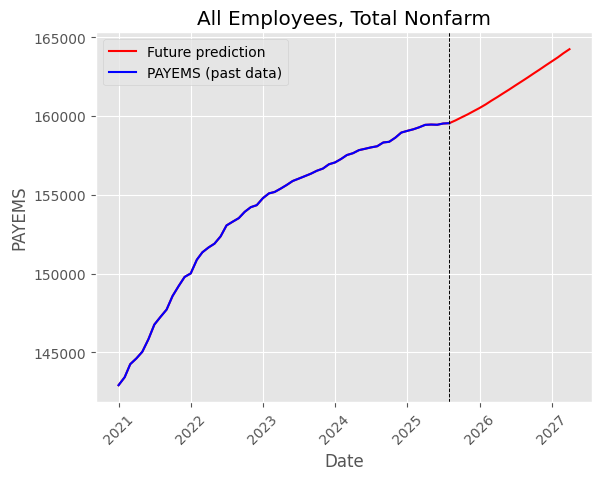

In [329]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['pred_cpi'], label='Future prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['PAYEMS'], label='PAYEMS (past data)', color='blue')
plt.axvline(x=pd.to_datetime('2025-08-01'), color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('PAYEMS')
plt.title('All Employees, Total Nonfarm')
plt.xticks(rotation=45)
plt.legend();

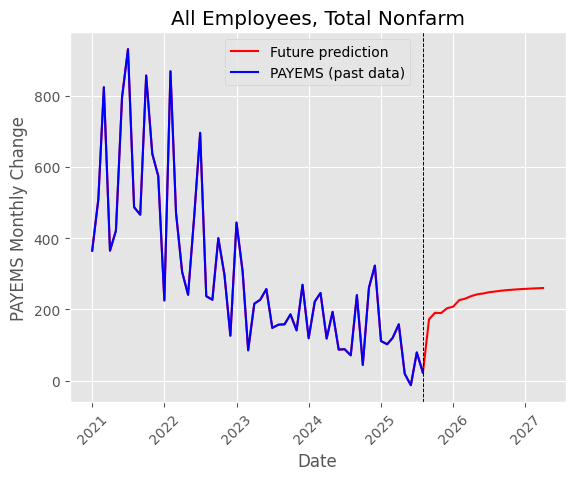

In [331]:
plt.plot(pred_df_rec['observation_date'], pred_df_rec['diffs_real'], label='Future prediction', color='red')
plt.plot(cpih_rec['observation_date'], cpih_rec['PAYEMS_delta'], label='PAYEMS (past data)', color='blue')
plt.axvline(x=pd.to_datetime('2025-08-01'), color='black', linestyle='--', linewidth=0.7)
plt.xlabel('Date')
plt.ylabel('PAYEMS Monthly Change')
plt.title('All Employees, Total Nonfarm')
plt.xticks(rotation=45)
plt.legend();